In [1]:
import os, json, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys, os
sys.path.append("..")
from src.tasks.game24 import Game24

In [2]:
lost_logs  = \
{
    "num_agents" : [3, 10, 5, 3, 10, 5],
    "difficulty" : [0, 0, 0, 0, 0, 0,],
    "model" : ["gpt-3.5-turbo-0125]\n(0 difficulty)"]*3 + ["gpt-3.5-turbo-1106]\n(0 difficulty)"]*3,
    "accuracy" : [5, 34, 18, 12, 44, 16],
    "cost" : [None]*6
}

df_lost = pd.DataFrame(lost_logs)
df_lost["backtrack"] = False
df_lost

,num_agents,difficulty,model,accuracy,cost,backtrack
0,3,0,gpt-3.5-turbo-0125]\n(0 difficulty),5,None,False
1,10,0,gpt-3.5-turbo-0125]\n(0 difficulty),34,None,False
2,5,0,gpt-3.5-turbo-0125]\n(0 difficulty),18,None,False
3,3,0,gpt-3.5-turbo-1106]\n(0 difficulty),12,None,False
4,10,0,gpt-3.5-turbo-1106]\n(0 difficulty),44,None,False
5,5,0,gpt-3.5-turbo-1106]\n(0 difficulty),16,None,False


In [3]:
def get_files_in_folder(folder_path):
    files = []
    for root, directories, filenames in os.walk(folder_path):
        for filename in filenames:
            files.append(os.path.join(root, filename))
    return files

def get_agents_difficulty_model(file_name):
    match = re.search(r'(\d+)agents.*_(\d+)start', file_name)

    if match:
        model = file_name.split("/")[-1].split("__")[0]
        num_agents = int(match.group(1))
        difficulty = int(int(match.group(2))/100)
        return num_agents, difficulty, model
    else:
        print("Pattern not found in file name:", file_name)

folder_path = '../logs_recent/analysis'
files_in_folder = get_files_in_folder(folder_path)
files_in_folder = [file for file in files_in_folder if file.endswith(".json")]

results = []
for file in files_in_folder:
    experiment = {}
    experiment["num_agents"], experiment["difficulty"], experiment["model"] = get_agents_difficulty_model(file)
    experiment["accuracy"] = Game24.get_accuracy(file, verbose=False)
    experiment["cost"] = Game24.get_cost(file, verbose=False)
    results.append(experiment)

df = pd.DataFrame(results)
df.sort_values(by=["difficulty", "model"], inplace=True)
df.reset_index(drop=True, inplace=True)
df["model"] = df.apply(lambda x: x["model"] + "\n(" + str(x["difficulty"])+" difficulty)", axis=1)
df["accuracy"] = df["accuracy"]*100
df["backtrack"] = True
display(df)

,num_agents,difficulty,model,accuracy,cost,backtrack
0,3,0,gpt-3.5-turbo-0125\n(0 difficulty),18.0,0.783629,True
1,10,0,gpt-3.5-turbo-0125\n(0 difficulty),64.0,2.001924,True
2,5,0,gpt-3.5-turbo-0125\n(0 difficulty),40.0,1.174844,True
3,3,0,gpt-3.5-turbo-1106\n(0 difficulty),26.0,1.195207,True
4,10,0,gpt-3.5-turbo-1106\n(0 difficulty),60.0,3.092521,True
5,5,0,gpt-3.5-turbo-1106\n(0 difficulty),30.0,1.905724,True


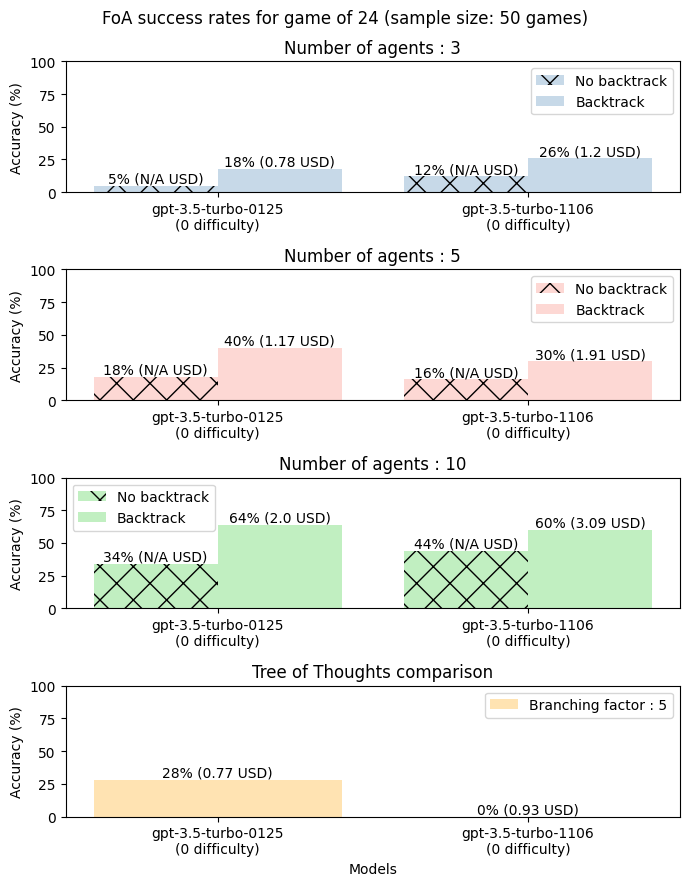

In [4]:
n_agents = [3, 5, 10]
fig, axes = plt.subplots(len(n_agents)+1, 1, figsize=(7,9))  # 2 rows, 1 column
colors = ["steelblue", "salmon", "limegreen"]
width = 0.4

for j, n in enumerate(n_agents):
    
    #####
    temp = df_lost[df_lost.num_agents == n]
    accuracies = temp.accuracy.tolist()
    models = temp.model.tolist()
    x_ticks= np.arange(len(models))
    costs = temp.cost.tolist()
    agents  = temp.num_agents.tolist()

    # Plotting accuracies
    color = colors[j]
    #axes[j].set_xlabel('Models')
    axes[j].set_ylabel('Accuracy (%)')
    bars = axes[j].bar(x=x_ticks-0.2, height=accuracies, color=color, alpha=0.3, label=f"No backtrack", width=width, hatch="x")
    axes[j].set_xticks(x_ticks, models)
    axes[j].tick_params(axis='y')
    axes[j].set_ylim(0, 100)
    axes[j].legend()

    for bar, acc, cost in zip(bars, accuracies, costs):
        axes[j].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{acc:.0f}% ({"N/A" if not cost else round(cost,2)} USD)', 
                     ha='center', va='bottom', color='black')
        
    ####
    temp = df[df.num_agents == n]
    accuracies = temp.accuracy.tolist()
    models = temp.model.tolist()
    x_ticks= np.arange(len(models))
    costs = temp.cost.tolist()
    agents  = temp.num_agents.tolist()

    # Plotting accuracies
    color = colors[j]
    #axes[j].set_xlabel('Models')
    axes[j].set_ylabel('Accuracy (%)')
    bars = axes[j].bar(x=x_ticks+0.2, height=accuracies, color=color, alpha=0.3, label=f"Backtrack", width=width)
    axes[j].set_xticks(x_ticks, models)
    axes[j].tick_params(axis='y')
    axes[j].set_ylim(0, 100)
    axes[j].legend()
    axes[j].set_title(f"Number of agents : {n}")

    for bar, acc, cost in zip(bars, accuracies, costs):
        axes[j].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{acc:.0f}% ({"N/A" if not cost else round(cost,2)} USD)', 
                     ha='center', va='bottom', color='black')

axes[3].set_title("Tree of Thoughts comparison")
axes[3].set_xlabel('Models')
axes[3].set_ylabel('Accuracy (%)')
tot_models = ["gpt-3.5-turbo-0125\n(0 difficulty)", "gpt-3.5-turbo-1106\n(0 difficulty)"]
tot_accuracies = [28, 0]
tot_costs = [0.77, 0.93]
bars = axes[3].bar(tot_models, tot_accuracies, color="orange", alpha=0.3, label=f"Branching factor : {5}")
axes[3].tick_params(axis='y')
axes[3].set_ylim(0, 100)
axes[3].legend()

for bar, acc, cost in zip(bars, tot_accuracies, tot_costs):
        axes[3].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{acc:.0f}% ({"N/A" if not cost else round(cost,2)} USD)', 
                     ha='center', va='bottom', color='black')


plt.suptitle("FoA success rates for game of 24 (sample size: 50 games)")
plt.tight_layout()
plt.savefig("../pics/accuracies_backtrack_foa.png", dpi=300)
plt.show()